# Countermeasures model v1

Changes:
* Fixed convolution by creating a tested library version
* Cleared up import code, removed obsolete mask, added text cells
* Improve plotting & writeouts
* Renamed from "basic" to v1 (this is hardly a simple model)
* Use exp(-gamma) as CMReduction prior
* Use Active in place of Confirmed for exp growth
* Use medium noise variances
* Use top 20 "JH Confirmed" European countries

## Import & initialization

In [1]:
### Initial imports
%load_ext autoreload
%autoreload 2

import datetime
import io
import logging
from pathlib import Path

import dateutil
import datetime
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel import RegionDataset, read_csv, Level
from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Loading data and parameter settings

In [2]:
# One-shot: selct most-infected countries
jh = read_csv('../data/johns-hopkins.csv')
Cs0 = ["BG", "UA", "PT", "IS", "RO", "HU", "IT", "HR", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "HU", "NO", "RO", "SE", "SI", "SK"]
Cs0 = sorted(set(Cs0), key=lambda c: jh.loc[c, "Confirmed"].max())

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']



Countermeasures                            min   .. mean  .. max
 0 Gatherings limited to 10                   0.000 .. 0.184 .. 1.000  {0.0, 1.0}
 1 Gatherings limited to 100                  0.000 .. 0.272 .. 1.000  {0.0, 1.0}
 2 Gatherings limited to 1000                 0.000 .. 0.301 .. 1.000  {0.0, 1.0}
 3 Business suspended - some                  0.000 .. 0.319 .. 1.000  {0.0, 1.0}
 4 Business suspended - many                  0.000 .. 0.224 .. 1.000  {0.0, 1.0}
 5 Schools and universities closed            0.000 .. 0.366 .. 1.000  {0.0, 1.0}
 6 General curfew - permissive                0.000 .. 0.196 .. 1.000  {0.0, 1.0}
 7 General curfew - strict                    0.000 .. 0.186 .. 1.000  {0.0, 1.0}


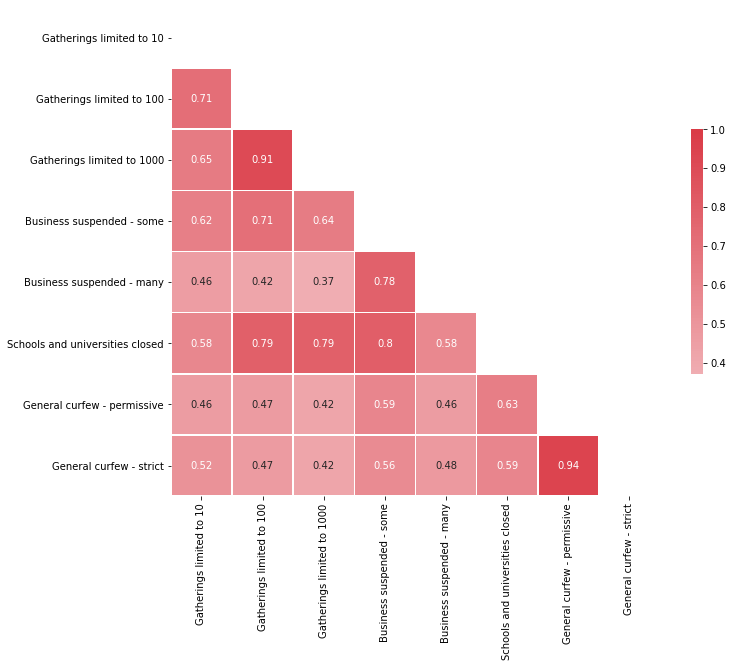

In [10]:
# Days
Ds = pd.date_range(start='2020-02-10', end='2020-04-05', tz='utc')
nDs = len(Ds)

Cs = ['IS', 'UA', 'GR', 'FI', 'RO', 'CZ', 'PL', 'DK', 'NO', 'SE', 'AT', 'PT', 'NL', 'CH', 'BE', 'GB', 'FR', 'DE', 'IT', 'ES']
nCs = len(Cs)

CMs = [#'Masks over 60',
 #'Asymptomatic contact isolation',
 'Gatherings limited to 10',
 'Gatherings limited to 100',
 'Gatherings limited to 1000',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
 'General curfew - permissive',
 'General curfew - strict',
 #'Healthcare specialisation over 0.2'
]
nCMs = len(CMs)

data = cm_effect.Loader('2020-02-10', '2020-04-05', Cs, CMs, active_cm_file='countermeasures-model-0to1-split.csv')
data.print_stats()

ActiveCMs = data.ActiveCMs
Confirmed = data.Confirmed
Active = data.Active
CMDelayCut = 10
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])

dcs = {}
for cmi, cm in enumerate(CMs):
    dcs[cm] = []
    for ci in range(nCs):
        dcs[cm].extend(np.convolve(ActiveCMs[ci, cmi, :], DelayProb))
dcs = pd.DataFrame(dcs)
corr = dcs.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, center=0, annot=True,
            square=True, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5})

def statstr(d):
    return f"{d.mean():.3g} ({np.quantile(d, 0.05):.3g} .. {np.quantile(d, 0.95):.3g})"

## Model definition

In [4]:
with pm.Model() as model:
    # [country] Initial size of epidemic (the day before the start, only those detected; wide prior OK)
    InitialSize = pm.Lognormal("InitialSize", 0.0, 20, shape=(nCs,))
    
    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryGrowthRate = pm.Lognormal("CountryGrowthRate", pm.math.log(1.3), 0.3, shape=(nCs,))
    
    # [CM] How much countermeasures reduce growth rate
    # TODO: Possibly use another distribution
    CMReductionGamma = pm.Gamma("CMReductionGamma", 0.5, 1.0, shape=(nCMs,))
    CMReduction = pm.Deterministic("CMReduction", T.exp((-1.0) * CMReductionGamma))

    # [country, CM, day] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReduction, (1, nCMs, 1)) ** ActiveCMs
    
    # [country, day] Reduction factor from CMs for each C,D (noise added below)
    GrowthReduction = pm.Deterministic("GrowthReduction", T.prod(ActiveCMReduction, axis=1))

    # [country, day] Convolution of GrowthReduction by DelayProb along days
    DelayedGrowthReduction = geom_convolution(GrowthReduction, DelayProb, axis=1)

    # Erase early DlayedGrowthRates in first ~10 days (would assume them non-present otherwise!)
    DelayedGrowthReduction = DelayedGrowthReduction[:, CMDelayCut:]
    
    # [country, day - CMDelayCut] The ideal predicted daily growth
    PreictedGrowth = pm.Deterministic("PredictedGrowth",
        T.reshape(CountryGrowthRate, (nCs, 1)) * DelayedGrowthReduction)
    
    # [country, day - CMDelayCut] The actual (still hidden) growth each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyGrowth =  pm.Lognormal("DailyGrowth", pm.math.log(PreictedGrowth), 0.07, shape=(nCs, nDs - CMDelayCut))

    # Below I assume plain exponentia growth of confirmed rather than e.g. depending on the remaining
    # susceptible opulation etc.

    # [country, day - CMDelayCut] The number of cases that would be detected with noiseless testing
    # (Noise source includes both false-P/N rates and local variance in test volume and targetting)
    # (Since we ony care about growth rates and assume consistent testing, it is fine to ignore real size)
    Size = pm.Deterministic("Size", T.reshape(InitialSize, (nCs, 1)) * DailyGrowth.cumprod(axis=1))

    # [country, day - CMDelayCut] Cummulative tested positives
    Observed = pm.Lognormal("Observed", pm.math.log(Size), 0.4, shape=(nCs, nDs - CMDelayCut), observed=Active[:, CMDelayCut:])


/home/gavento/proj/epimodel/.venv/lib/python3.6/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


## Run MCMC inference

1000 steps is enough for seeing the convergence and rough results, more is better, though.

In [5]:
print(model.check_test_point())
with model:
    trace = pm.sample(4000, chains=3, cores=3, init='adapt_diag', tune=2000, max_treedepth=15, target_accept=0.9)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


InitialSize_log__              -78.29
CountryGrowthRate_log__          5.70
CMReductionGamma_log__         -11.35
DailyGrowth_log__             1601.10
Observed_missing                 0.00
Observed                  -2105150.91
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Observed_missing, DailyGrowth, CMReductionGamma, CountryGrowthRate, InitialSize]
INFO:pymc3:NUTS: [Observed_missing, DailyGrowth, CMReductionGamma, CountryGrowthRate, InitialSize]
Sampling 3 chains, 267 divergences: 100%|██████████| 18000/18000 [2:10:32<00:00,  2.30draws/s]   
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8253852841227713, but should be close to 0.9. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There we

## Plot chain stability

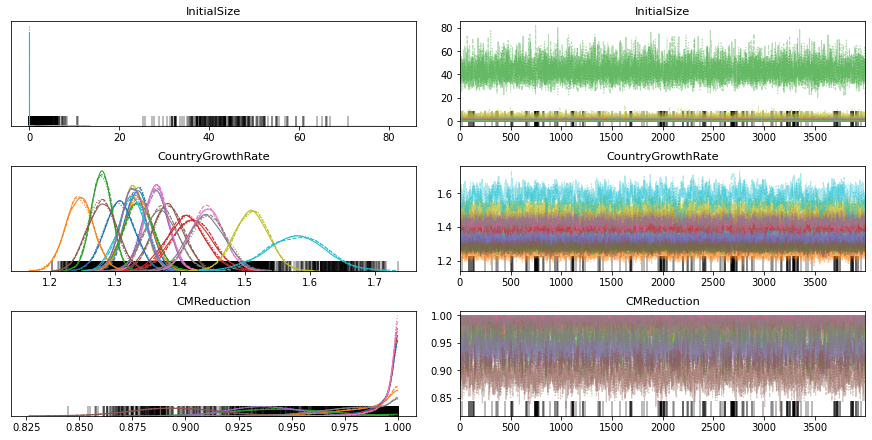

In [6]:
_ = pm.traceplot(trace, var_names=["InitialSize", "CountryGrowthRate", "CMReduction"])

## Plot inferred countermeasure effect

Effects are multiplicative (e.g. for a countermeasure that is a strenghtening of another, the inferred strenght is the additional multiplier).

The countermeasure strength is the multiplicative effect at feature=1.0.

 0 Gatherings limited to 10                 CMReduction 0.995 (0.981 .. 1)
 1 Gatherings limited to 100                CMReduction 0.985 (0.954 .. 1)
 2 Gatherings limited to 1000               CMReduction 0.944 (0.908 .. 0.982)
 3 Business suspended - some                CMReduction 0.996 (0.984 .. 1)
 4 Business suspended - many                CMReduction 0.937 (0.911 .. 0.964)
 5 Schools and universities closed          CMReduction 0.895 (0.864 .. 0.928)
 6 General curfew - permissive              CMReduction 0.996 (0.985 .. 1)
 7 General curfew - strict                  CMReduction 0.98 (0.952 .. 1)


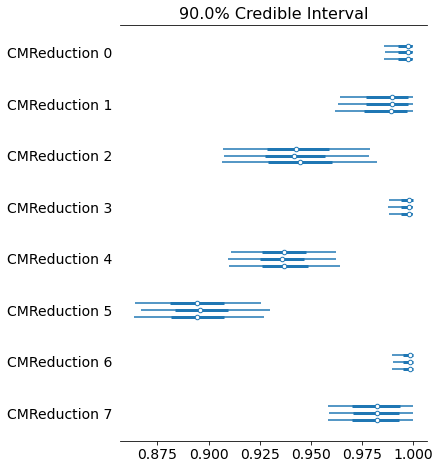

In [7]:
pm.forestplot(trace, var_names=['CMReduction'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReduction {statstr(trace['CMReduction'][:,i])}")

Cummulated CM effects
 0 Gatherings limited to 10                 CMReduction_cumul 0.924 (0.892 .. 0.958)
 1 Gatherings limited to 100                CMReduction_cumul 0.929 (0.896 .. 0.963)
 2 Gatherings limited to 1000               CMReduction_cumul 0.944 (0.908 .. 0.982)
 3 Business suspended - some                CMReduction_cumul 0.996 (0.984 .. 1)
 4 Business suspended - many                CMReduction_cumul 0.933 (0.906 .. 0.96)
 5 Schools and universities closed          CMReduction_cumul 0.895 (0.864 .. 0.928)
 6 General curfew - permissive              CMReduction_cumul 0.996 (0.985 .. 1)
 7 General curfew - strict                  CMReduction_cumul 0.976 (0.949 .. 0.998)


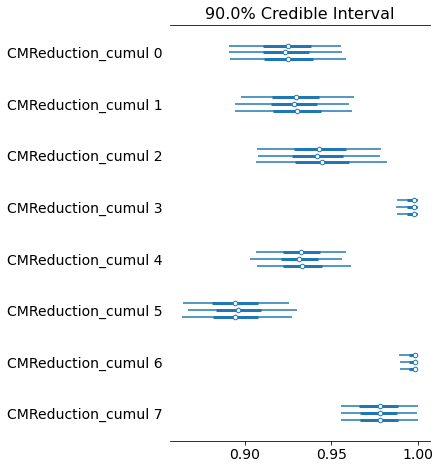

In [9]:
print("Cummulated CM effects")

a = trace['CMReduction']
a[:, 1] *= a[:, 2]
a[:, 0] *= a[:, 1]
a[:, 4] *= a[:, 3]
a[:, 7] *= a[:, 6]
from copy import deepcopy
trace.add_values({'CMReduction_cumul': a}, True)

pm.forestplot(trace, var_names=['CMReduction_cumul'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReduction_cumul {statstr(trace['CMReduction_cumul'][:,i])}")

In [ ]:
import plotly
from plotly import graph_objects as go
import plotly.express as px
import datetime

def plot_line_CIs(fig, x, ys, name, color, quantiles=(0.05, 0.25), opacities=(0.1, 0.15)):
    x=list(x)
    fig.add_trace(go.Scatter(
        x=x,
        y=list(ys.mean(axis=0)),
        name=name, legendgroup=name, line_color=color
    ))    
    for q, o in zip(quantiles, opacities):
        ylo = list(np.quantile(ys, q, axis=0))
        yhi = list(np.quantile(ys, 1.0-q, axis=0))
        fig.add_trace(go.Scatter(
            x=x + x[::-1],
            y=ylo+yhi[::-1],
            fill='toself',
            fillcolor=color,
            opacity=o,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=name, legendgroup=name,
        ))    
        
fig = go.FigureWidget()
for i, c in enumerate(Cs):
    d = trace['DailyGrowth'][:,i,:]
    color = (px.colors.qualitative.Dark24 * 10)[i]
    plot_line_CIs(fig, Ds[CMDelayCut:], d, c, color)
datestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plotly.io.write_html(fig, f'{datestr}_growth_estimated_v1.html', include_plotlyjs='cdn')
fig